In [145]:
#import libraries
%matplotlib inline
import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
#import files
from load_datas import *
from constants import *
from visualization import *
from data_processing import *
from cnn import *
from helpers import *

In [147]:
imgs, gt_imgs = load_datas(NB_IMAGES_MAX)

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


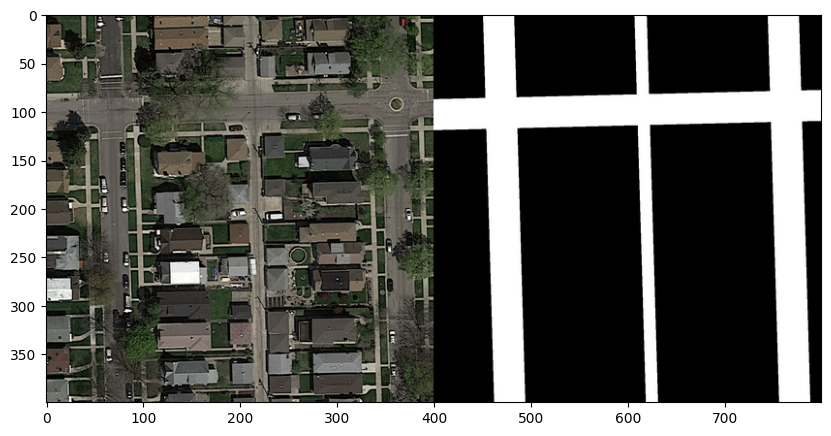

In [148]:
visualize(imgs, gt_imgs, index=5)

In [149]:
Processing = ProcessingData(imgs, gt_imgs)
Processing.create_patches()
Processing.create_labels()
Processing.create_sets()

Creating patches...
Done!
Creating labels...
Done!
Splitting data...
Done!


In [150]:
print(Processing.imgs_train.shape)
print(Processing.gt_imgs_train.shape)
print(Processing.imgs_test.shape)
print(Processing.gt_imgs_test.shape)

(35000, 16, 16, 3)
(35000,)
(8750, 16, 16, 3)
(8750,)


In [151]:
# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Compute features for each image patch
foreground_threshold = (
    0.25  # percentage of pixels > 1 required to assign a foreground label to a patch
)


def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0


X = np.asarray([extract_features_2d(Processing.imgs_train[i]) for i in range(len(Processing.imgs_train))])
Y = np.asarray([value_to_class(np.mean(Processing.gt_imgs_train[i])) for i in range(len(Processing.gt_imgs_train))])

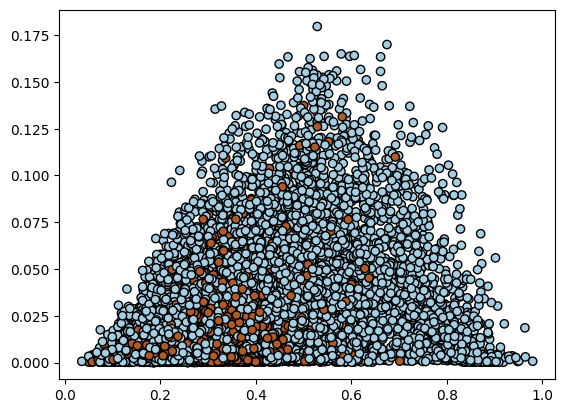

In [152]:
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors="k", cmap=plt.cm.Paired)

### Basic CNN 

Epoch 1/20, Loss: 0.49284098673548016, Validation Accuracy: 0.7554, F1 score: 0.3642
Epoch 2/20, Loss: 0.4566769963366645, Validation Accuracy: 0.7754, F1 score: 0.3564
Epoch 3/20, Loss: 0.41807927813870566, Validation Accuracy: 0.7969, F1 score: 0.5217
Epoch 4/20, Loss: 0.4231195943049022, Validation Accuracy: 0.7808, F1 score: 0.3670
Epoch 5/20, Loss: 0.38552272455011094, Validation Accuracy: 0.8107, F1 score: 0.5598
Epoch 6/20, Loss: 0.39425711095503396, Validation Accuracy: 0.8063, F1 score: 0.5363
Epoch 7/20, Loss: 0.39781834540537425, Validation Accuracy: 0.7982, F1 score: 0.4709
Epoch 8/20, Loss: 0.40273408489738194, Validation Accuracy: 0.8063, F1 score: 0.5785
Epoch 9/20, Loss: 0.39011180320807864, Validation Accuracy: 0.8181, F1 score: 0.6275
Epoch 10/20, Loss: 0.4182657497831753, Validation Accuracy: 0.7993, F1 score: 0.4646
Epoch 11/20, Loss: 0.4353828607950892, Validation Accuracy: 0.7993, F1 score: 0.4942
Epoch 12/20, Loss: 0.39575160155296324, Validation Accuracy: 0.8139

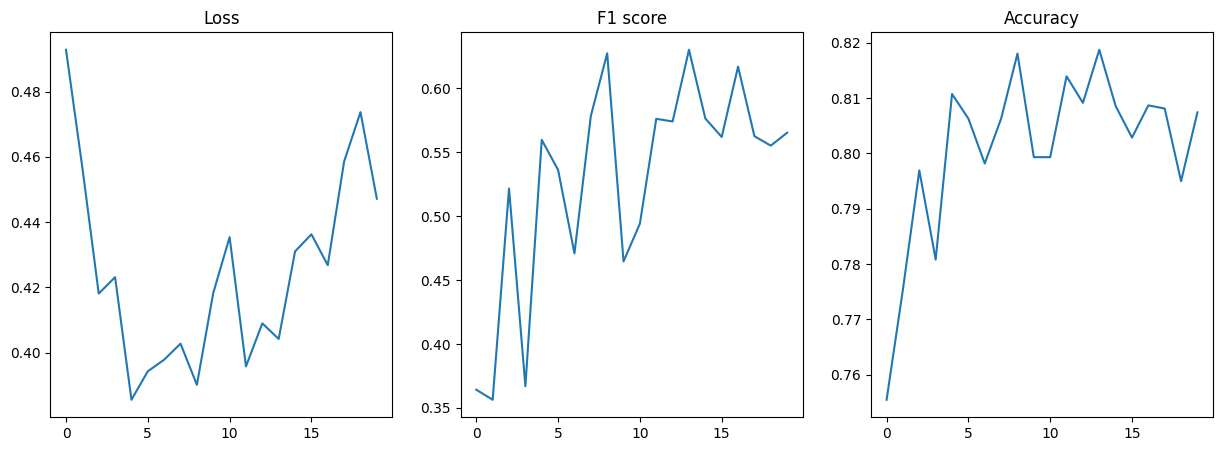

In [159]:
from torchvision import transforms
from cnn import *

cnn = Basic_CNN(PATCH_SIZE)

# Create tensors for training and validation labels
train_labels = torch.tensor(Processing.gt_imgs_train)
test_labels = torch.tensor(Processing.gt_imgs_test)

transform = transforms.Compose([
    transforms.ToTensor(),
])

imgs_train = [transform(img) for img in Processing.imgs_train]
imgs_test = [transform(img) for img in Processing.imgs_test]

train_images = torch.stack(imgs_train)
test_images = torch.stack(imgs_test)

# Create TensorDataset instances for training and validation
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

cnn.train_model(optimizer, criterion, train_loader, test_loader, num_epochs=20)

In [160]:
valid_labels = torch.tensor(Processing.gt_imgs_validation)
imgs_valid = [transform(img) for img in Processing.imgs_validation]
valid_images = torch.stack(imgs_valid)
valid_loader = DataLoader(valid_images, batch_size=32, shuffle=False)

preds = cnn.predict(test_loader=valid_loader)

sum(preds.ravel() == valid_labels.numpy().ravel()) / len(preds.ravel())


0.8119466666666667

In [161]:
f1_score(preds.ravel(), valid_labels.numpy().ravel())

0.5781287389327591

In [156]:
def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            im[j : j + w, i : i + h] = labels[idx]
            idx = idx + 1
    return im
def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:, :, 0] = predicted_img * 255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, "RGB").convert("RGBA")
    overlay = Image.fromarray(color_mask, "RGB").convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

In [157]:
patch_size = 16
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray(
        [extract_features_2d(img_patches[i]) for i in range(len(img_patches))]
    )
    return X

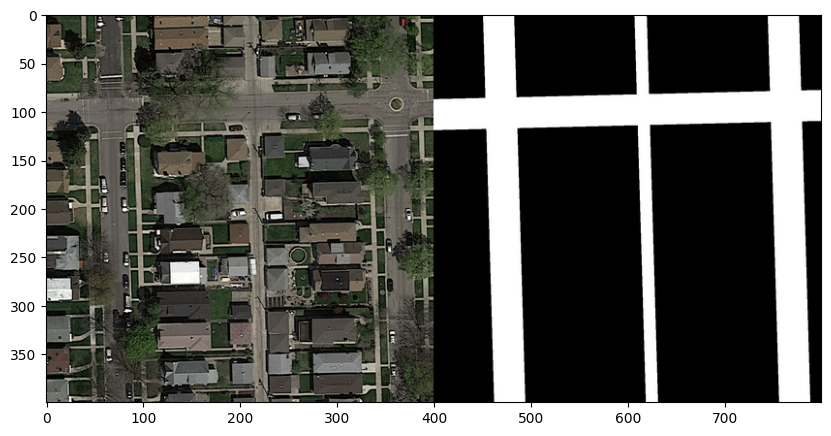

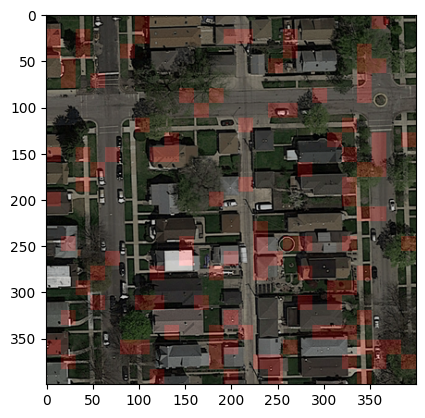

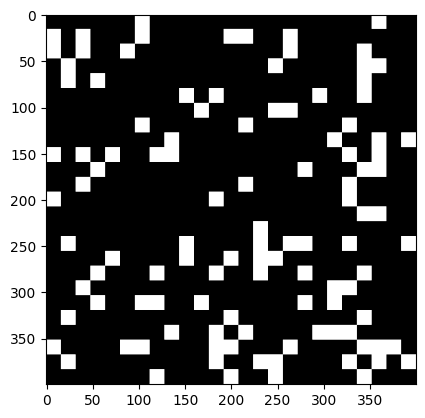

In [158]:
img_idx = 5
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, preds)
cimg = concatenate_images(imgs[img_idx], gt_imgs[img_idx])
fig1 = plt.figure(figsize=(10, 10))  # create a figure with the default size
plt.imshow(cimg, cmap="Greys_r")
plt.show()

new_img = make_img_overlay(imgs[img_idx], predicted_im)
plt.imshow(new_img)
plt.show()

plt.imshow(predicted_im, cmap="Greys_r")
plt.show()



## CIFAR

c:\DATA\git_fork\ml-project-2-team-slo\source\helpers.py:91: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


Epoch 1/10, Loss: 0.693147182559967, Validation Accuracy: 0.7405, F1 score: nan
Epoch 2/10, Loss: 0.693147182559967, Validation Accuracy: 0.7405, F1 score: nan
Epoch 3/10, Loss: 0.693147182559967, Validation Accuracy: 0.7405, F1 score: nan
Epoch 4/10, Loss: 0.693147182559967, Validation Accuracy: 0.7405, F1 score: nan
Epoch 5/10, Loss: 0.693147182559967, Validation Accuracy: 0.7405, F1 score: nan
Epoch 6/10, Loss: 0.693147182559967, Validation Accuracy: 0.7405, F1 score: nan
Epoch 7/10, Loss: 0.693147182559967, Validation Accuracy: 0.7405, F1 score: nan
Epoch 8/10, Loss: 0.693147182559967, Validation Accuracy: 0.7405, F1 score: nan
Epoch 9/10, Loss: 0.693147182559967, Validation Accuracy: 0.7405, F1 score: nan
Epoch 10/10, Loss: 0.693147182559967, Validation Accuracy: 0.7405, F1 score: nan


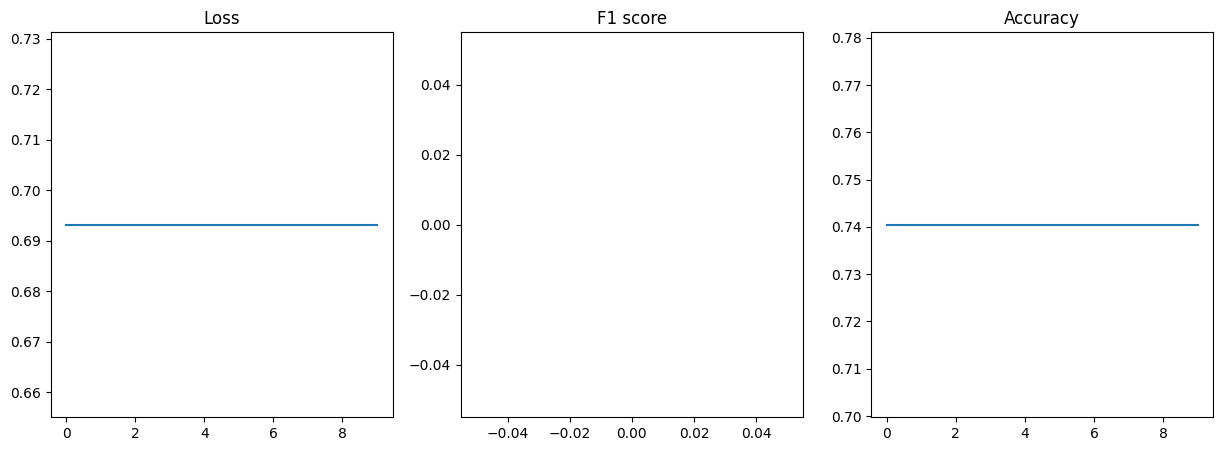

In [166]:
from torchvision import transforms
from cnn import *


# Create tensors for training and validation labels
train_labels = torch.tensor(Processing.gt_imgs_train)
test_labels = torch.tensor(Processing.gt_imgs_test)

transform = transforms.Compose([
    transforms.ToTensor(),
])

imgs_train = [transform(img) for img in Processing.imgs_train]
imgs_test = [transform(img) for img in Processing.imgs_test]

train_images = torch.stack(imgs_train)
test_images = torch.stack(imgs_test)

# Create TensorDataset instances for training and validation
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

cnn_cifar = CNN_CIFAR(PATCH_SIZE)


optimizer = torch.optim.Adam(cnn_cifar.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

cnn_cifar.train_model(optimizer, criterion, train_loader, test_loader, num_epochs=10)



In [168]:
class CNN_CIFAR(nn.Module):
    def __init__(self, patch_size):
        super(CNN_CIFAR, self).__init__()
        self.patch_size = patch_size
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.maxpool(self.relu(self.conv4(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x
    
    def train_model(self, optimizer, criterion, train_loader, val_loader, num_epochs=10):
        losses = []
        F1_score = []
        acc = []
        for epoch in range(num_epochs):
            self.train()
            for input, target in train_loader:
                optimizer.zero_grad()
                output = self(input)
                target = target.float().view(-1, 1)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
        
            # Validation loop
            self.eval()
            # Disable gradient calculation for validation
            with torch.no_grad():
                total_correct = 0
                test_loss = 0
                tot_preds = []
                tot_targets = []
                for input, target in val_loader:
                    output = self(input)
                    predictions = (output > FOREGROUND_THRESHOLD).float()
                    target = target.float().view(-1, 1)
                    total_correct += (predictions == target).sum().item()
                    test_loss += criterion(output, target).item() * len(input)
                    tot_preds.append(predictions)
                    tot_targets.append(target)

                test_loss /= len(val_loader.dataset)
                accuracy = total_correct / len(val_loader.dataset)
                f1 = f1_score(torch.cat(tot_preds).numpy(), torch.cat(tot_targets).numpy())
                print(f'Epoch {epoch+1}/{num_epochs}, Loss: {test_loss}, Validation Accuracy: {accuracy:.4f}, F1 score: {f1:.4f}')
                losses.append(test_loss)
                F1_score.append(f1)
                acc.append(accuracy)
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].plot(range(num_epochs),losses)
        axes[0].set_title('Loss')
        axes[1].plot(range(num_epochs),F1_score)
        axes[1].set_title('F1 score')
        axes[2].plot(range(num_epochs),acc)
        axes[2].set_title('Accuracy')
        plt.show()
    
    def predict(self, test_loader):
        """Predict the labels of the test set."""
        self.eval()
        predictions = []
        with torch.no_grad():
            for input in test_loader:
                output = self(input)
                output = (output > FOREGROUND_THRESHOLD).float()
                predictions.append(output)
        return torch.cat(predictions).numpy()


In [169]:
valid_labels = torch.tensor(Processing.gt_imgs_validation)
imgs_valid = [transform(img) for img in Processing.imgs_validation]
valid_images = torch.stack(imgs_valid)
valid_loader = DataLoader(valid_images, batch_size=32, shuffle=False)

preds = cnn_cifar.predict(test_loader=valid_loader)

sum(preds.ravel() == valid_labels.numpy().ravel()) / len(preds.ravel())

AttributeError: 'CNN_CIFAR' object has no attribute 'predict'